In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
! conda install -y gdown

Retrieving notices: ...working... done
Channels:
 - rapidsai
 - nvidia
 - nodefaults
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-24.9.1               |  py310hff52083_0         894 KB  conda-forge
    filelock-3.16.1            |     pyhd8ed1ab_0          17 KB  conda-forge
    gdown-5.2.0                |     pyhd8ed1ab_0          21 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         932 KB

The following NEW packages will be INSTALLED:

  filelock           conda-forge/noarch::filelock-3.16.1-pyhd8ed1ab_0 
  gdown              conda-forge/noarch::gdo

In [3]:
!gdown --id 1qzxDtizk4HqHC87cUkeNDqXq8FiWPGbp

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1qzxDtizk4HqHC87cUkeNDqXq8FiWPGbp
To: /kaggle/working/NETFLIX.zip
100%|██████████████████████████████████████| 21.4k/21.4k [00:00<00:00, 36.5MB/s]


In [4]:
import zipfile
z= zipfile.ZipFile('NETFLIX.zip')
z.extractall()

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score,mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,Dropout,BatchNormalization,Input
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [6]:
df = pd.read_csv('/kaggle/working/NFLX.csv')  # Replace with your file path

In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
data = df['Adj Close'].values.reshape(-1, 1)

In [8]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [9]:
seq_length = 60
X, y = [], []
for i in range(len(scaled_data) - seq_length):
    X.append(scaled_data[i:(i + seq_length)])
    y.append(scaled_data[i + seq_length])

X = np.array(X)
y = np.array(y)

In [10]:
# Split data into train and test sets
train_size = int(len(X) * 0.85)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [11]:
# Prepare data for ANN (flattened input)
X_train_ann = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test_ann = X_test.reshape(X_test.shape[0], X_test.shape[1])

In [12]:
# Create and train a more complex LSTM model
lstm_model = Sequential([
        LSTM(64, activation='tanh', input_shape=(seq_length, 1), 
             return_sequences=True, 
             kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        Dropout(0.2),
        LSTM(32, activation='tanh', 
             kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        Dropout(0.2),
        Dense(16, activation='relu', 
              kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        Dense(1)
    ])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
lstm_model.compile(optimizer='adam', loss='huber')  # Using Huber loss instead of MSE

In [14]:
early_stoppingg = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    mode='min'
)
model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

# Train the model
lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stoppingg, model_checkpoint],
    verbose=1
)

Epoch 1/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 0.0440 - val_loss: 0.0342
Epoch 2/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0198 - val_loss: 0.0185
Epoch 3/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0166 - val_loss: 0.0137
Epoch 4/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0134 - val_loss: 0.0114
Epoch 5/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0116 - val_loss: 0.0099
Epoch 6/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0105 - val_loss: 0.0089
Epoch 7/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0092 - val_loss: 0.0085
Epoch 8/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0083 - val_loss: 0.0071
Epoch 9/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0075 - val_loss: 0.0065
Epoch 10/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0071 - val_loss: 0.0066
Epoch 11/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0065 - val_loss: 0.0057
Epoch 12/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

In [15]:
# Create and train ANN model
ann_model = Sequential([
    Dense(100, activation='relu', input_shape=(seq_length,)),
    Dense(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(1)
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
ann_model.compile(optimizer='adam', loss='mse')

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
ann_history = ann_model.fit(
    X_train_ann, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0379 - val_loss: 0.0045
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0040 - val_loss: 0.0024
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.

In [18]:
# Make predictions
ann_train_predict = ann_model.predict(X_train_ann)
ann_test_predict = ann_model.predict(X_test_ann)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [19]:
# Make predictions
lstm_train_predict = lstm_model.predict(X_train)
lstm_test_predict = lstm_model.predict(X_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [20]:
# Inverse transform predictions
ann_train_predict = scaler.inverse_transform(ann_train_predict)
ann_test_predict = scaler.inverse_transform(ann_test_predict)
lstm_train_predict = scaler.inverse_transform(lstm_train_predict)
lstm_test_predict = scaler.inverse_transform(lstm_test_predict)
y_train_inv = scaler.inverse_transform(y_train)
y_test_inv = scaler.inverse_transform(y_test)

In [21]:
# Calculate metrics
def calculate_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return r2, rmse

In [22]:
ann_train_r2, ann_train_rmse = calculate_metrics(y_train_inv, ann_train_predict)
ann_test_r2, ann_test_rmse = calculate_metrics(y_test_inv, ann_test_predict)
lstm_train_r2, lstm_train_rmse = calculate_metrics(y_train_inv, lstm_train_predict)
lstm_test_r2, lstm_test_rmse = calculate_metrics(y_test_inv, lstm_test_predict)

In [23]:
print("ANN Metrics:")
print(f"Train R2: {ann_train_r2:.4f}, Train RMSE: {ann_train_rmse:.4f}")
print(f"Test R2: {ann_test_r2:.4f}, Test RMSE: {ann_test_rmse:.4f}")
print("\nLSTM Metrics:")
print(f"Train R2: {lstm_train_r2:.4f}, Train RMSE: {lstm_train_rmse:.4f}")
print(f"Test R2: {lstm_test_r2:.4f}, Test RMSE: {lstm_test_rmse:.4f}")

ANN Metrics:
Train R2: 0.9841, Train RMSE: 11.0714
Test R2: 0.9183, Test RMSE: 20.9734

LSTM Metrics:
Train R2: 0.9685, Train RMSE: 15.5980
Test R2: 0.8144, Test RMSE: 31.6039


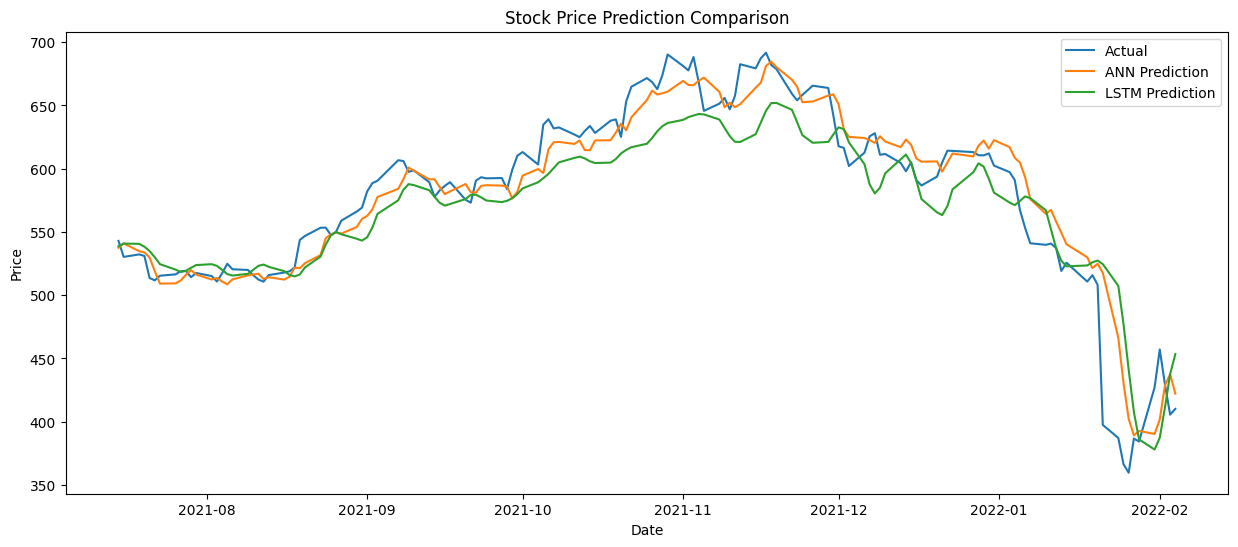

In [24]:
# Plot predictions
plt.figure(figsize=(15, 6))
plt.plot(df.index[seq_length+train_size:], y_test_inv, label='Actual')
plt.plot(df.index[seq_length+train_size:], ann_test_predict, label='ANN Prediction')
plt.plot(df.index[seq_length+train_size:], lstm_test_predict, label='LSTM Prediction')
plt.title('Stock Price Prediction Comparison')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

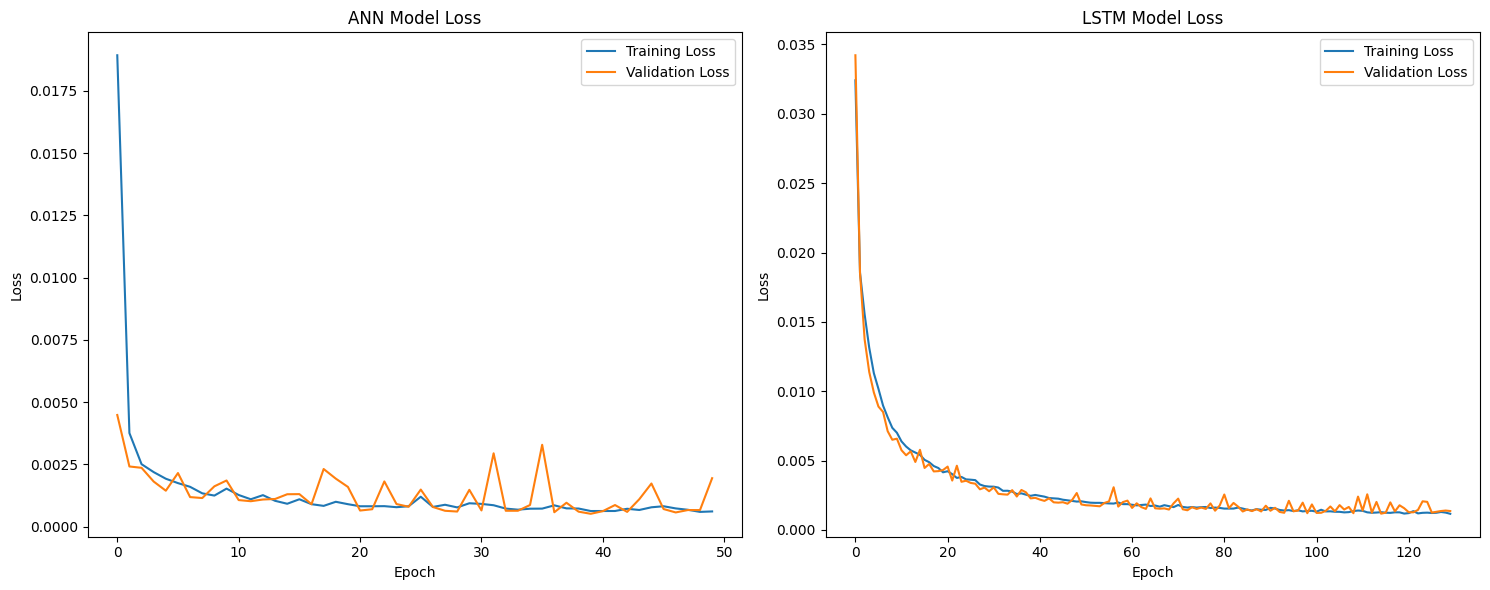

In [25]:
# Plot training history comparison
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(ann_history.history['loss'], label='Training Loss')
plt.plot(ann_history.history['val_loss'], label='Validation Loss')
plt.title('ANN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
#Future predictions
last_sequence = scaled_data[-seq_length:]
last_sequence_flat = last_sequence.reshape(1, seq_length)
last_sequence_3d = last_sequence.reshape(1, seq_length, 1)

ann_next_day = scaler.inverse_transform(ann_model.predict(last_sequence_flat))[0][0]
lstm_next_day = scaler.inverse_transform(lstm_model.predict(last_sequence_3d))[0][0]

print(f"ANN Predicted next day price: {ann_next_day:.2f}")
print(f"LSTM Predicted next day price: {lstm_next_day:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
ANN Predicted next day price: 409.89
LSTM Predicted next day price: 452.46
